<div align="center">

# Understanding Community Needs Through 911 Call Patterns  
## Eduardo Medina

</div>


# Table of Contents

1. [Introduction](#introduction)
2. [Load](#load)
3. [Data Exploration](#data-exploration)
4. [Geospatial and Temporal Analysis](#geospatial-and-temporal-analysis)
5. [Feature Creation](#feature-creation)
6. [Data Standardization and Linear Model](#data-standardization-and-linear-model)
7. [Observations and Recommendation](#observations-and-recommendation)


<a id="introduction"></a>

# Introduction

Calls for Service (CFS) are not typically used as a direct measure of crime or public safety, but they can reveal important patterns about community needs and the demand placed on law enforcement. Public safety agencies aim to reduce non-emergency calls to ensure that resources are allocated efficiently and emergency responses are not delayed.

This project aims to better understand these dynamics by answering the following questions:

- What are the patterns behind calls to the police across ZIP codes?  
- How do factors like education, employment, and community infrastructure play a role?

The analysis was conducted using data and context specific to the City of San Antonio.


<a id="load"></a>

# Load

In [1]:
import pandas as pd

# Load dataset
file_path = "Data_Sets/SAPD_Calls_for_Service.csv"
df = pd.read_csv(file_path)


<a id="data-exploration"></a>

# Data Exploration

In [2]:
# Date Ranges
print(df["Response_Date"].min())
print(df["Response_Date"].max())

# Look at data set info
print("Dataset Info:")
print(df.info())

# Loof for missing values
missing_values = df.isna().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Look at first rows of data
print(df.head(5))

# Drop duplicate rows
df_cleaned = df.drop_duplicates()

print(df.shape)
print(df_cleaned.shape)

# Look at the different types of calls
print(df_cleaned["Problem"].unique()[:5])  # show first 10 unique values

group_by_Problem_Priority_DP = df_cleaned.groupby(["Problem", "Priority", "Disposition_Groups"]).size().reset_index(name="Count")
group_by_Problem_Priority_DP.head(5)

2023-01-01 00:00:12.000
2025-02-28 23:59:44.000
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360000 entries, 0 to 3359999
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   _id                     int64  
 1   Master_Incident_Number  object 
 2   Response_Date           object 
 3   Priority                float64
 4   Problem                 object 
 5   Service_Area            object 
 6   Type                    object 
 7   Seconds                 float64
 8   Weekday                 object 
 9   Disposition_Groups      object 
 10  Disposition_Type        object 
 11  Postal_Code             object 
 12  DateTime                object 
dtypes: float64(2), int64(1), object(10)
memory usage: 333.3+ MB
None

Missing Values in Each Column:
_id                            0
Master_Incident_Number         2
Response_Date                  0
Priority                       3
Problem                        0
Ser

,Problem,Priority,Disposition_Groups,Count
0,911 Hang Up,5.0,Cancelled Request,42462
1,911 Hang Up,5.0,Cleared-Agg Assault,28
2,911 Hang Up,5.0,Cleared-Burg Business,13
3,911 Hang Up,5.0,Cleared-Burg Hab,25
4,911 Hang Up,5.0,Cleared-Burg Veh,13


After inspecting the data, we decided to remove certain types of calls to better reflect local crime levels, since we intend to use call volume per ZIP code area as a metric of crime. Priority appears to be descending, with Priority 1 representing high urgency and Priority 10 low, so Priority 10 was excluded. We also removed calls like Prisoner Transport, which don’t represent new or location-specific crimes. Similarly, ID Theft and Internet Predator cases were excluded, as they may not be directly associated with incidents occurring within the area. Lastly, Priority 99, which typically involves SWAT activity, was removed as it likely reflects exceptional situations.

In [3]:
# Remove priority 10 and 99
df_cleaned.drop(df_cleaned.loc[df_cleaned["Priority"].isin([10, 99])].index, inplace=True)

calls_to_remove = [
    "Prisoner Transport",
    "Internet Predator",
    "ID Theft"
]

# Some of the calls have more importance than others.
print(df_cleaned.shape)

df_cleaned = df_cleaned[~df_cleaned["Problem"].isin(calls_to_remove)]

print(df_cleaned.shape)

# Inspect ZipCodes
group_by_Zip = df_cleaned.groupby(["Postal_Code"]).size().reset_index(name="Count")

# Zip codes were found that oculd be removed.
# Show table with zipcodes to remove
print(group_by_Zip[group_by_Zip["Postal_Code"].isin(["Out of Jurisdiction", "Not Listed", "78155"])])

(3359952, 13)
(3344231, 13)
            Postal_Code   Count
7                 78155       5
75           Not Listed  125399
76  Out of Jurisdiction      13


We notice that we have "Out of Jurisdiction" and "Not Listed". We decide to remove these points since we are interested in looking at call counts per ZIP code area. For "Not Listed", since we do not have access to the full details of the police report using the "Master_Incident_Number", we decided to remove them from the study. It should not affect results since it's just $\sim 3.7%$ of the data so far. We also removed ZIP code 78155 (Seguin, TX), as it is outside of San Antonio and only 5 calls were made from that location over the two-year time span.

In [4]:
# Remove "Out of Jurisdiction", "Not Listed", and 78155
df_cleaned.drop(df_cleaned[df_cleaned["Postal_Code"].isin(["Out of Jurisdiction", "Not Listed", "78155"])].index, inplace=True)
# df_cleaned.to_csv("df_cleaned.csv", index = False)
df_cleaned["Priority"].isna().value_counts()

# Get number of calls per ZIP
zip_counts = df_cleaned["Postal_Code"].value_counts().reset_index()
zip_counts.columns = ["Postal_Code", "Call_Count"]

## Visualizations and Plots

### Figure 1

From the Bexar County Open Data portal (https://gis-bexar.opendata.arcgis.com/datasets/Bexar::bexar-county-zip-code-areas/explore), which provides public GIS datasets for the region, we obtained the shapefile containing the boundaries and area for each ZIP code zone in San Antonio. We imported the data and merged it with the number of calls per ZIP code.

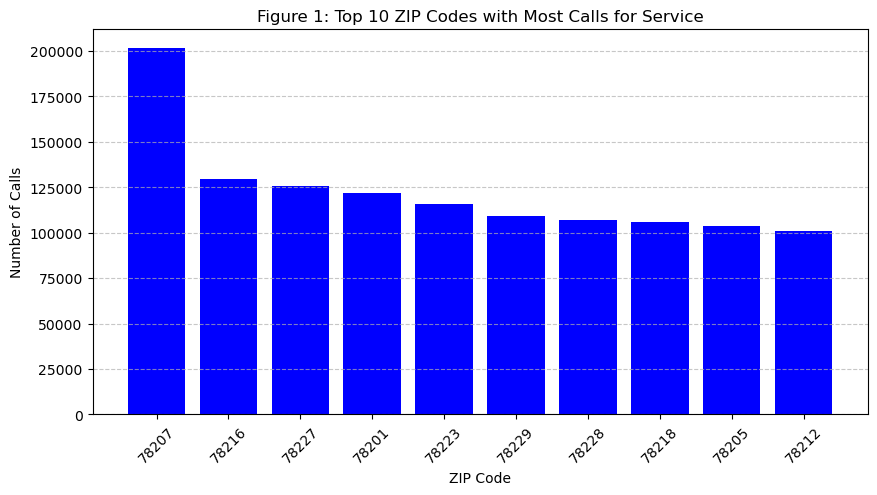

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(zip_counts["Postal_Code"][:10], zip_counts["Call_Count"][:10], color="blue")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Calls")
plt.title("Figure 1: Top 10 ZIP Codes with Most Calls for Service")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Figure 2

We can see that the monthly distribution of calls appears relatively uniform throughout the year. The two visible spikes are likely due to having data for 2025 only through January and February. Therefore, we will simply divide the total number of calls by the time range to calculate the average number of calls per year.

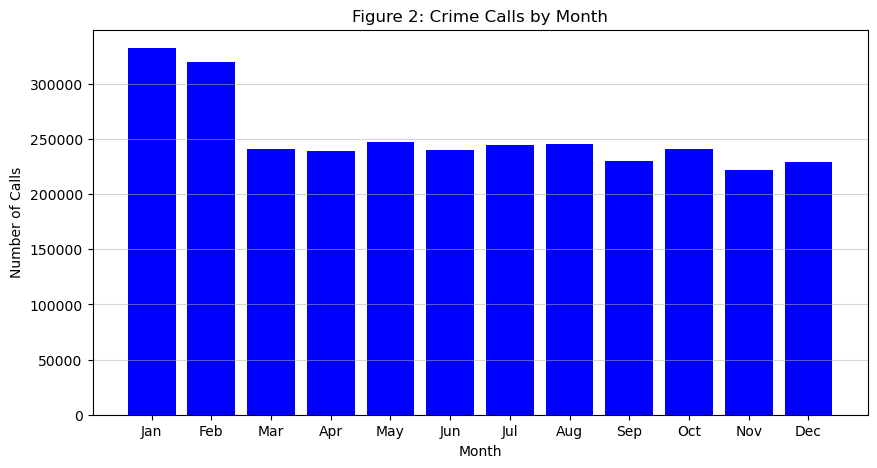

In [6]:
df_cleaned["Response_Date"] = pd.to_datetime(df_cleaned["Response_Date"], errors="coerce")

# Extract month from timestamp
df_cleaned["Month"] = df_cleaned["Response_Date"].dt.month

# Count calls per month
monthly_calls = df_cleaned["Month"].value_counts().sort_index()

# Month labels
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot monthly crime trends
plt.figure(figsize=(10, 5))
plt.bar(months, monthly_calls.values, color="blue")
plt.xlabel("Month")
plt.ylabel("Number of Calls")
plt.title("Figure 2: Crime Calls by Month")
plt.grid(axis="y", alpha=0.5)

# Show plot
plt.show()

### Figure 3

From figure 3, we observe an inflection point around 8 a.m. and a second major inflection point around 7 p.m. This suggests that most calls occur during typical business hours.









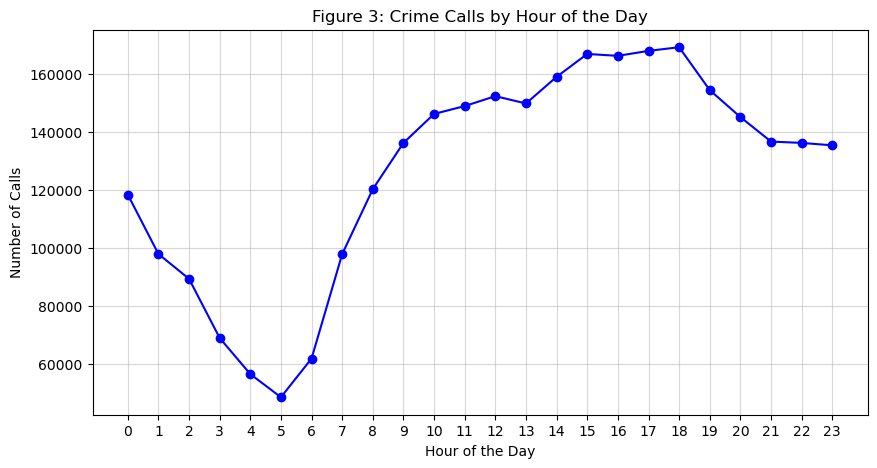

In [7]:
# Get hour
df_cleaned["Hour"] = df_cleaned["Response_Date"].dt.hour

# Count calls per hour
hourly_calls = df_cleaned["Hour"].value_counts().sort_index()

# Plot counts vs hour of day
plt.figure(figsize=(10, 5))
plt.plot(hourly_calls.index, hourly_calls.values, marker="o", linestyle="-", color="blue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Calls")
plt.title("Figure 3: Crime Calls by Hour of the Day")
plt.xticks(range(0, 24))  # Show all 24 hours
plt.grid(alpha=0.5)

# Show plot
plt.show()

<a id="geospatial-and-temporal-analysis"></a>

# Geospatial and Temporal Analysis

In [8]:
# Import package to read shp files and visualize
import geopandas as gpd

# Find time frame
print(df_cleaned["Response_Date"].max()-df_cleaned["Response_Date"].min())

789 days 23:59:32


We have 789 days, therefore the time range is:


$$
\frac{789\text{days}}{365\text{days/year}}\approx2.16\text{years}
$$

Dividing the total number of calls by this time range gives the average number of calls per year.

In [9]:
zip_counts["Call_Count_per_Year"] = zip_counts["Call_Count"]/(789/365)

# Load San Antonio ZIP code shapefile. epsg=4326 to use proper latitude and longitude.
gdf = gpd.read_file( "Data_Sets/Bexar_County_ZIP_Code_Areas/Bexar_County_ZIP_Code_Areas.shp").to_crs(epsg=4326)

# Merge with call count data
gdf = gdf.merge(zip_counts, how="inner", left_on="ZIP", right_on="Postal_Code")

print(df["Postal_Code"].isin(["78148"]).value_counts())
print(df["Postal_Code"].isin(["78150"]).value_counts())


Postal_Code
False    3360000
Name: count, dtype: int64
Postal_Code
False    3360000
Name: count, dtype: int64


### Figure 4

A choropleth map can be plotted to visualize the areas with higher crime rates, using the number of calls per ZIP code as a metric. We divide by the total time frame in years to get an average

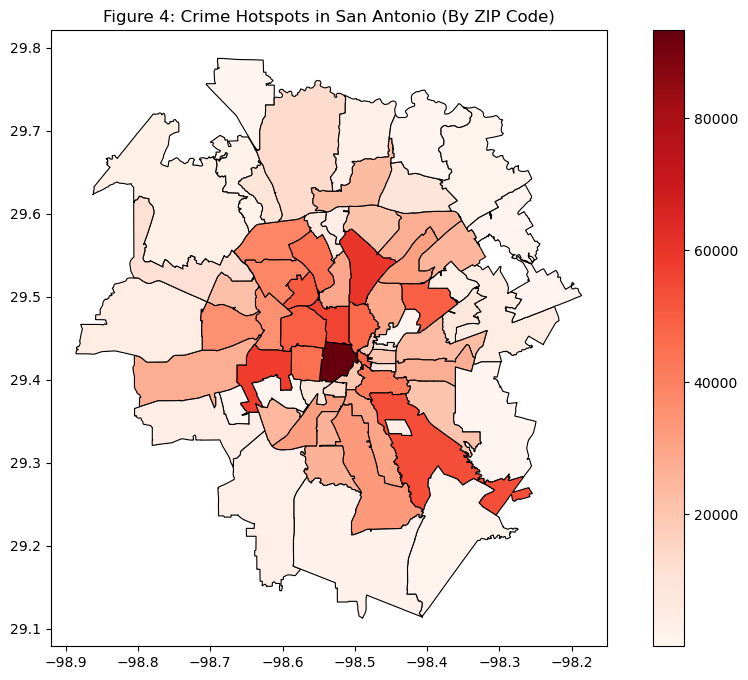

In [10]:
gdf.plot(column="Call_Count_per_Year", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, figsize=(12, 8))
plt.title("Figure 4: Crime Hotspots in San Antonio (By ZIP Code)")
plt.show()

<a id="feature-creation"></a>

# Feature Creation

## Higher Education Enrollment

We used data from the U.S. Census Bureau: https://data.census.gov. Specifically, we referenced Table ID S1501 – Educational Attainment (ACS 5-Year Estimates Subject Tables), filtered by ZIP Code Tabulation Area for San Antonio.

### Note on 5-Year estimate
The 5-year estimate represents data collected over a 5-year period. In this case, it covers from January 1, 2019 to December 31, 2023, totaling 60 months of data collection. These estimates reflect average characteristics observed during that span, not year-by-year totals.

For more information, please visit:
https://www.census.gov/programs-surveys/acs/guidance/estimates.html

In [11]:
edf = pd.read_csv("Data_Sets/EducationACSST5Y2023/ACSST5Y2023.S1501-Data.csv", dtype=str, low_memory=False, header = 1)

# Generate txt file to Manually filter columns of interest
with open("Data_Sets/EducationACSST5Y2023/edf_columns.txt", "w") as f:
    for col in edf.columns:
        f.write(col + "\n")

# Keep filetered names
column_filtered = open("Data_Sets/EducationACSST5Y2023/edf_columns_filtered.txt").read().splitlines()
edf = edf[column_filtered]
edf[edf.columns[2:]] = edf[edf.columns[2:]].astype(float)

# Rename
edf = edf.rename(columns={
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years": "Pop18To24",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years": "Pop18To24MoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree": "Pop18To24SomeCollege",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree": "Pop18To24SomeCollegeMoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Bachelor's degree or higher": "Pop18To24Bachelors",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Bachelor's degree or higher": "Pop18To24BachelorsMoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over": "Pop25Plus",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over": "Pop25PlusMoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree": "Pop25PlusSomeCollege",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree": "Pop25PlusSomeCollegeMoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree": "Pop25PlusAssociates",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree": "Pop25PlusAssociatesMoE",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher": "Pop25PlusBachelors",
    "Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher": "Pop25PlusBachelorsMoE"
})

### Post-processing

When looking at the data, we see that educational attainment levels are provided for the population aged 18 and over. We count the population from those with "Some College" through "Bachelor's degree or higher" and refer to this variable as College Enrollment. This is done to explore the impact of higher education participation on crime rate.

In [12]:
# Clean the Zip code data.
edf["ZipClean"] = edf["Geographic Area Name"].str.replace("ZCTA5 ", "", regex=False)

# Get Total enrolled for 18 to 24
edf["Pop18To24EnrolledCollege"] = edf["Pop18To24SomeCollege"] + edf["Pop18To24Bachelors"]

# Get Total enrolled for 25 and up
edf["Pop25PlusEnrolledCollege"] = edf["Pop25PlusSomeCollege"] + edf["Pop25PlusAssociates"] + edf["Pop25PlusBachelors"]

# Add to get total enrolled from 18 and up.
edf["TotalEnrolled"] = edf["Pop18To24EnrolledCollege"] + edf["Pop25PlusEnrolledCollege"]

## Income

For income, we use Table S1901: Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars) from the U.S. Census Bureau. The same filter as above is applied, using ZIP Code Tabulation Areas for San Antonio.

In [13]:
idf = pd.read_csv("Data_Sets/IncomeACSST5Y2023/ACSST5Y2023.S1901-Data.csv", dtype=str, low_memory=False, header = 1)
idf["ZipClean"] = idf["Geographic Area Name"].str.replace("ZCTA5 ", "", regex=False)
idf = idf.loc[idf["ZipClean"].isin(gdf.Postal_Code.unique())]

# Manually filter columns names to keep
with open("Data_Sets/IncomeACSST5Y2023/idf_columns.txt", "w") as f:
    for col in idf.columns:
        f.write(col + "\n")

# Keep filetered names
column_filtered = open("Data_Sets/IncomeACSST5Y2023/idf_columns_filtered.txt").read().splitlines()
idf = idf[column_filtered]

idf[idf.columns[2:]] = idf[idf.columns[2:]].astype(float)
idf["ZipClean"] = idf["Geographic Area Name"].str.replace("ZCTA5 ", "", regex=False)

# Rename
idf = idf.rename(columns={
    "Estimate!!Households!!Total":"HHCount",
    "Margin of Error!!Households!!Total":"HHCountMoE",
    "Estimate!!Households!!Median income (dollars)":"HHMedianIncome",
    "Margin of Error!!Households!!Median income (dollars)":"HHMedianIncomeMoE",
    "Estimate!!Households!!Mean income (dollars)": "HHMeanIncome",
    "Margin of Error!!Households!!Mean income (dollars)": "HHMeanIncomeMoE"
})

# We multiply the mean household income for each ZIP code by the total number
# of households in that ZIP to estimate the total income for each area.
idf["ZIPTotalIncome"] = idf["HHMeanIncome"]*idf["HHCount"]

## Unemployment Rate

For unemployment, we use Table S2301: Employment Status from the U.S. Census Bureau, filtered by ZIP Code Tabulation Area for San Antonio.

For this study, we want to account for ZIP-level differences by weighting certain features based on the characteristics of each area. In this case, we scale by the labor force per ZIP code. This is based on two main assumptions: (1) individuals aged 16 and older are the ones likely to place calls to law enforcement, and (2) scaling by labor force allows us to adjust for differences in population size across ZIP codes.

We can calculate the total labor force using the following relationship:

$$
\text{Labor Force Rate} = \frac{\text{Labor Force}}{\text{Population}}
$$

From this, the total labor force can be estimated by multiplying the labor force rate by the total working-age population.

In [14]:
udf = pd.read_csv("Data_Sets/EmploymentACSST5Y2023/ACSST5Y2023.S2301-Data.csv", dtype=str, low_memory=False, header = 1)
udf["ZipClean"] = udf["Geographic Area Name"].str.replace("ZCTA5 ", "", regex=False)
udf = udf.loc[udf["ZipClean"].isin(gdf.Postal_Code.unique())]

# Manually filter columns names to keep
with open("Data_Sets/EmploymentACSST5Y2023/udf_columns.txt", "w") as f:
    for col in udf.columns:
        f.write(col + "\n")

# Keep filetered names
column_filtered = open("Data_Sets/EmploymentACSST5Y2023/udf_columns_filtered.txt").read().splitlines()
udf = udf[column_filtered]

# Rename
udf = udf.rename(columns={
    "Estimate!!Total!!Population 16 years and over": "PopTotal",
    "Margin of Error!!Total!!Population 16 years and over": "PopTotalMoE",
    "Estimate!!Labor Force Participation Rate!!Population 16 years and over": "LFR",
    "Margin of Error!!Labor Force Participation Rate!!Population 16 years and over": "LFRMoE",
    "Estimate!!Unemployment rate!!Population 16 years and over": "URate",
    "Margin of Error!!Unemployment rate!!Population 16 years and over": "URateMoE"
})

# Change type for the following to use for calculations
udf["PopTotal"] = udf["PopTotal"].astype(float)
udf["LFR"] = udf["LFR"].astype(float)
udf["URate"] = udf["URate"].astype(float)

udf["LF"] = udf["LFR"]/100 * udf["PopTotal"]

### Understanding effect of community infrastructure

Now we take a look at community infrastructure, specifically libraries. Libraries can contribute to the improvement of high-crime areas by supporting education, literacy, and providing access to community programs. We obtained the total number of libraries from the San Antonio Open Data site: https://opendata-cosagis.opendata.arcgis.com/search, by searching for the Libraries dataset.

## Libraries

In [15]:
# Load library shp file
ldf = gpd.read_file( "Data_Sets/Libraries/Libraries.shp").to_crs(epsg=4326)

print(ldf["Zipcode"].value_counts().head(5))

# Make library categorical since there is about 1 library per zip code.

# Remove duplicate rows based on zip codes
ldf_no_duplicate_zip = ldf.drop_duplicates(subset="Zipcode", keep="first").copy()
ldf_no_duplicate_zip["Library"] = 1 # We will take care for the rest of the zip codes later below.

Zipcode
78222    2
78212    2
78228    2
78250    2
78227    2
Name: count, dtype: int64


## SParkSites
From the San Antonio Open Data site:

“A SPARK Park is a school that receives money from the city in order to keep the gates open during the day until sundown to the public.”

Public parks like SPARK sites promote recreational activities and access to shared space, which may help reduce crime rates by promoting positive community engagement. We looked at the SPark Sites data set.

In [16]:
# Load SPark Sites data
sdf = gpd.read_file( "Data_Sets/SparkSites/SparkSites.shp").to_crs(epsg=4326)
sdf["ZipCode"] = sdf["ZipCode"].astype(object)

# After exploring the data I noticed that some zips were missing

dummy_index = sdf.loc[sdf["ZipCode"] == 0].index
sdf.loc[sdf["ZipCode"] == 0]
# 1500 Evans Rd, San Antonio, TX 78258
# 401 Berkshire, San Antonio, TX 78210
# 247 Bangor Dr, San Antonio, TX 78228
# 9627 Adams Hill Dr, San Antonio, TX 78245

# Add corresponding zips
sdf.loc[dummy_index,"ZipCode"] = [78258, 78210,78228, 78245 ]
sdf["ZipCode"] = sdf["ZipCode"].astype(str)

sdf["ZipCode"].value_counts()

# Remove duplicate rows based on zip codes
sdf_no_duplicate_zip = sdf.drop_duplicates(subset="ZipCode", keep="first").copy()
sdf_no_duplicate_zip["SparkSite"] = 1 # We will take care for the rest of the zip codes later below.

## SAPD SAFFE Zones
The San Antonio Open Data site provides access to the SAPD SAFFE Zones dataset, which outlines the zones patrolled by SAFFE (San Antonio Fear Free Environment) officers from the City of San Antonio Police Department. We will explore the impact of the area covered by these patrol zones on local crime patterns.

In [17]:
zdf = gpd.read_file( "Data_Sets/SAPDSAFFEZones/SAPDSAFFEZones.shp").to_crs(epsg=4326)


print(gdf.columns)
print(zdf.columns)

Index(['OBJECTID', 'PO_NAME', 'STATE', 'SQMI', 'ZIP', 'Lng', 'Lat',
       'ShapeSTAre', 'ShapeSTLen', 'geometry', 'Postal_Code', 'Call_Count',
       'Call_Count_per_Year'],
      dtype='object')
Index(['Service_Ar', 'SAFFEZone', 'Districts', 'SqMiles', 'created_da',
       'Website', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')


### Figure 5

Explore the zones on top of the San Antonio map.

Figure 5 below shows that the SAFFE Zones extend beyond the boundaries of individual ZIP codes. To account for this, we need to reshape the geometry and calculate the area of overlap between each SAFFE Zone and ZIP code.

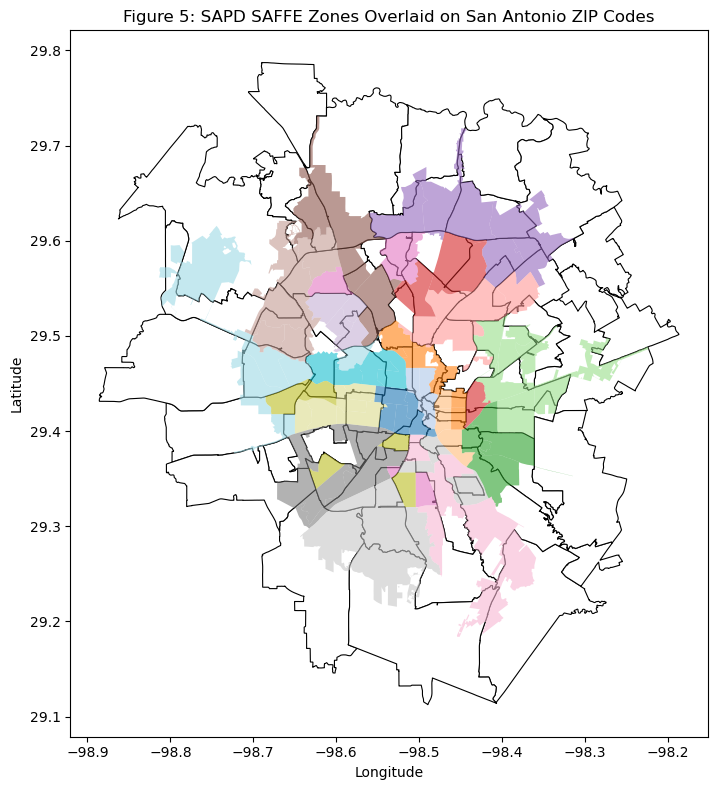

In [18]:
# Plot both shape files
fig, ax = plt.subplots(figsize=(12, 8))

# Remember gdf this is the geo variable for the zip shapes
gdf.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=0.8)

# SAFFE zones
zdf.plot(ax=ax, column="SAFFEZone", cmap="tab20", legend=False, edgecolor="none", alpha=0.6)

# Clean up and label
ax.set_title("Figure 5: SAPD SAFFE Zones Overlaid on San Antonio ZIP Codes")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


### Postprocessing

In [19]:
# Get Spatial intersection (ZIPs ∩ SAFFE Zones)
zdf_overlap = gpd.overlay(gdf[["ZIP", "geometry"]], zdf[["SAFFEZone", "geometry"]], how="intersection")

# Calculate area of each intersected polygon
zdf_overlap["OverlapArea"] = zdf_overlap.geometry.area

# Reorder or filter columns
zdf_overlap = zdf_overlap[["ZIP", "SAFFEZone", "geometry", "OverlapArea"]]
print(zdf_overlap)

# Group by ZIP and dissolve geometries
zdf_dissolved = zdf_overlap.dissolve(by="ZIP", as_index=False)

# Add total area per ZIP (geometry is already dissolved)
zdf_dissolved["TotalOverlapArea"] = zdf_dissolved.geometry.area

# Compare total area
print(zdf["SHAPE_Area"].sum())
print(zdf_dissolved["TotalOverlapArea"].sum())

# The total area is different, likely due to not using proper units.

# Set EPSG:2278 to get usual area units (Texas South Central)
zdf_dissolved_proj = zdf_dissolved.to_crs(epsg=2278)

# Recalculate the area
zdf_dissolved_proj["TotalOverlapAreaSqrFt"] = zdf_dissolved_proj.geometry.area

# Compare again
print("Original zdf total area:", zdf["SHAPE_Area"].sum())
print("Recomputed overlap area:", zdf_dissolved_proj["TotalOverlapAreaSqrFt"].sum())

# Get percentage
print(zdf_dissolved_proj["TotalOverlapAreaSqrFt"].sum()/zdf["SHAPE_Area"].sum())

# The areas are now the same.

# Add proper column with area units (likely ft^2)
zdf_dissolved = zdf_dissolved.merge(zdf_dissolved_proj[["ZIP", "TotalOverlapAreaSqrFt"]], on="ZIP", how="left")


       ZIP SAFFEZone                                           geometry  \
0    78023      P-10  MULTIPOLYGON (((-98.65074 29.61814, -98.65077 ...   
1    78023      W-12  POLYGON ((-98.74757 29.53664, -98.74766 29.536...   
2    78023      P-11  MULTIPOLYGON (((-98.66774 29.55403, -98.6678 2...   
3    78073      S-08  POLYGON ((-98.65046 29.31945, -98.65046 29.319...   
4    78073      S-11  POLYGON ((-98.65029 29.31956, -98.64939 29.320...   
..     ...       ...                                                ...   
347  78263      E-09  POLYGON ((-98.36078 29.3636, -98.36079 29.3638...   
348  78263      E-12  POLYGON ((-98.33605 29.41864, -98.33588 29.418...   
349  78264      S-03  MULTIPOLYGON (((-98.42374 29.23097, -98.42369 ...   
350  78264      S-13  POLYGON ((-98.58402 29.25467, -98.58401 29.254...   
351  78266      N-09  MULTIPOLYGON (((-98.31343 29.6023, -98.31325 2...   

      OverlapArea  
0    1.107086e-03  
1    3.834158e-03  
2    1.132062e-04  
3    3.429220e-04  

/var/folders/1w/byd48zb55rnbh_x6sbljbvg40000gn/T/ipykernel_15052/1335179597.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zdf_overlap["OverlapArea"] = zdf_overlap.geometry.area
/var/folders/1w/byd48zb55rnbh_x6sbljbvg40000gn/T/ipykernel_15052/1335179597.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zdf_dissolved["TotalOverlapArea"] = zdf_dissolved.geometry.area


### Figure 6

Figure 6 now shows a single color within each ZIP code area. Although some colors repeat since the software uses similar shades for numerically close ZIP codes, we can confirm that the rearrangement worked properly because each boundary contains only one color. This indicates that the areas were successfully dissolved by ZIP code.

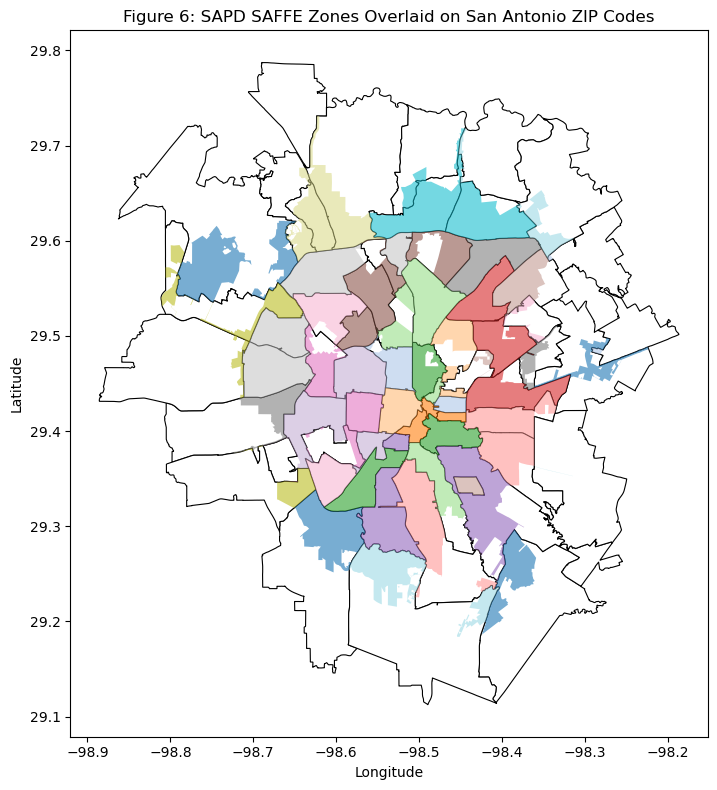

In [20]:
# Plot both shape files
fig, ax = plt.subplots(figsize=(12, 8))

# Remember "gdf" this is the geo variable for the zip shapes
gdf.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=0.8)

# SAFFE zones
zdf_dissolved.plot(ax=ax, column="ZIP", cmap="tab20", legend=False, edgecolor="none", alpha=0.6)

ax.set_title("Figure 6: SAPD SAFFE Zones Overlaid on San Antonio ZIP Codes")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

### Postprocessing

We notice that the SAFFE Zones do not go over one of the zip zones. We will take into account for that.

In [21]:
# Merge income data
merged_df = gdf.merge(idf, how="left", left_on="ZIP", right_on="ZipClean")

# Merge Education data
merged_df = merged_df.merge(edf, how="left", left_on="ZIP", right_on="ZipClean")

# Merge Unemployment data
merged_df = merged_df.merge(udf, how="left", left_on="ZIP", right_on="ZipClean")

# Merge SAFFE Zone area
merged_df = merged_df.merge(zdf_dissolved[["ZIP", "TotalOverlapAreaSqrFt" ]], left_on="ZIP", right_on="ZIP", how="left")
# Fill NaN values 0, this indicates that the SAFFE Zone does not cover one zip zone
merged_df["TotalOverlapAreaSqrFt"] = merged_df["TotalOverlapAreaSqrFt"].fillna(0).astype(int)

# Merge Library data
merged_df = merged_df.merge(ldf_no_duplicate_zip[["Zipcode", "Library"]], left_on="ZIP", right_on="Zipcode", how="left")
# Fill NaN values 0, this indicates no library
merged_df["Library"] = merged_df["Library"].fillna(0).astype(int)

# Merge SPark data
merged_df = merged_df.merge(sdf_no_duplicate_zip[["ZipCode", "SparkSite"]], left_on="ZIP", right_on="ZipCode", how="left")
# Fill NaN values 0, this indicates no SPark
merged_df["SparkSite"] = merged_df["SparkSite"].fillna(0).astype(int)

We will scale some of the features by dividing them by the total Labor Force in each ZIP code. This aligns with the two assumptions mentioned earlier regarding who can make calls and how to normalize across ZIP codes. This divition will create rates with respect to working age person (WAP).

In [22]:


merged_df["TotalEnrolled_Scaled"] = merged_df["TotalEnrolled"] / merged_df["LF"]
merged_df["ZIPTotalIncome_Scaled"] = merged_df["ZIPTotalIncome"] /  merged_df["LF"]

merged_df["URate"] # No need to divide, it is already scaled with labor force

merged_df["Call_Count_Scaled"] = merged_df["Call_Count_per_Year"] / merged_df["LF"]

merged_df["TotalOverlapAreaSqrFt_Scaled"] = merged_df["TotalOverlapAreaSqrFt"] / merged_df["LF"]

# Make copy of the original and also standarized versions
merged_df_original = merged_df.copy()
# merged_df_original.to_csv("merged_df_original.csv", index=False)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = merged_df["Call_Count_Scaled"].quantile(0.25)
q3 = merged_df["Call_Count_Scaled"].quantile(0.75)
iqr = q3 - q1

# Get lower and upper bound
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Get outliers
outliers = merged_df[
    (merged_df["Call_Count_Scaled"] < lower_bound) |
    (merged_df["Call_Count_Scaled"] > upper_bound)
]

outliers[["ZIP", "Call_Count_Scaled"]]



,ZIP,Call_Count_Scaled
10,78205,53.184386
19,78215,6.440450


### Figure 7

Figure 7 presents a box plot highlighting two clear outliers: one ZIP code reporting approximately 6 calls per working-age person (WAP), and another reaching an extraordinary 53 calls per WAP. Since WAP is calculated based on the number of working-age residents, these figures suggest that the high call volumes are driven by non-resident activity such as commuters, local workers, or even tourists. This interpretation aligns with the fact that the ZIP codes in question encompass parts of downtown San Antonio, including the Pearl District and Broadway corridor. Given that these areas do not reflect the residential patterns of most ZIP codes in the city, we have opted to remove them from the analysis.

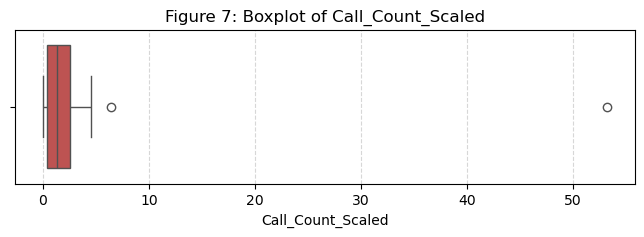

In [23]:
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.boxplot(x=merged_df_original["Call_Count_Scaled"], color="#CF4240")
plt.title("Figure 7: Boxplot of Call_Count_Scaled")
plt.xlabel("Call_Count_Scaled")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

<a id="data-standardization-and-linear-model"></a>

# Data Standardization and Linear Model

In [24]:
# Drop Outlayers
merged_df = merged_df[~merged_df["ZIP"].isin(["78205", "78215"])]

# Standarize data frame for OLS later

from sklearn.preprocessing import StandardScaler

binary_features = ["Library", "SparkSite"]
continuous_features = ["Call_Count_Scaled",
                       "URate",
                       "ZIPTotalIncome_Scaled",
                       "TotalEnrolled_Scaled",
                       "TotalOverlapAreaSqrFt_Scaled"
                      ]

features = continuous_features + binary_features

# Standardize only the continuous ones
scaler = StandardScaler()
merged_df_standardized = merged_df.copy()
merged_df_standardized[continuous_features] = scaler.fit_transform(merged_df[continuous_features])
# Binary ones stay the same

# Now merged_df_scaled has standardized continuous features and untouched binary ones
# merged_df_standardized.to_csv("merged_df_standardized.csv", index=False)

# Output data frame
# merged_df.to_csv("merged_df.csv", index = False)


### Figure 8

From Figure 8 below, it is difficult to visually assess the relationship between the selected features and Calls per Workforce Available Population (WAP). However, there appears to be a noticeable correlation between College Enrollment per WAP and Income per WAP, which may suggest potential collinearity in the regression model for later use. To better understand these relationships, we will proceed to construct a correlation matrix.

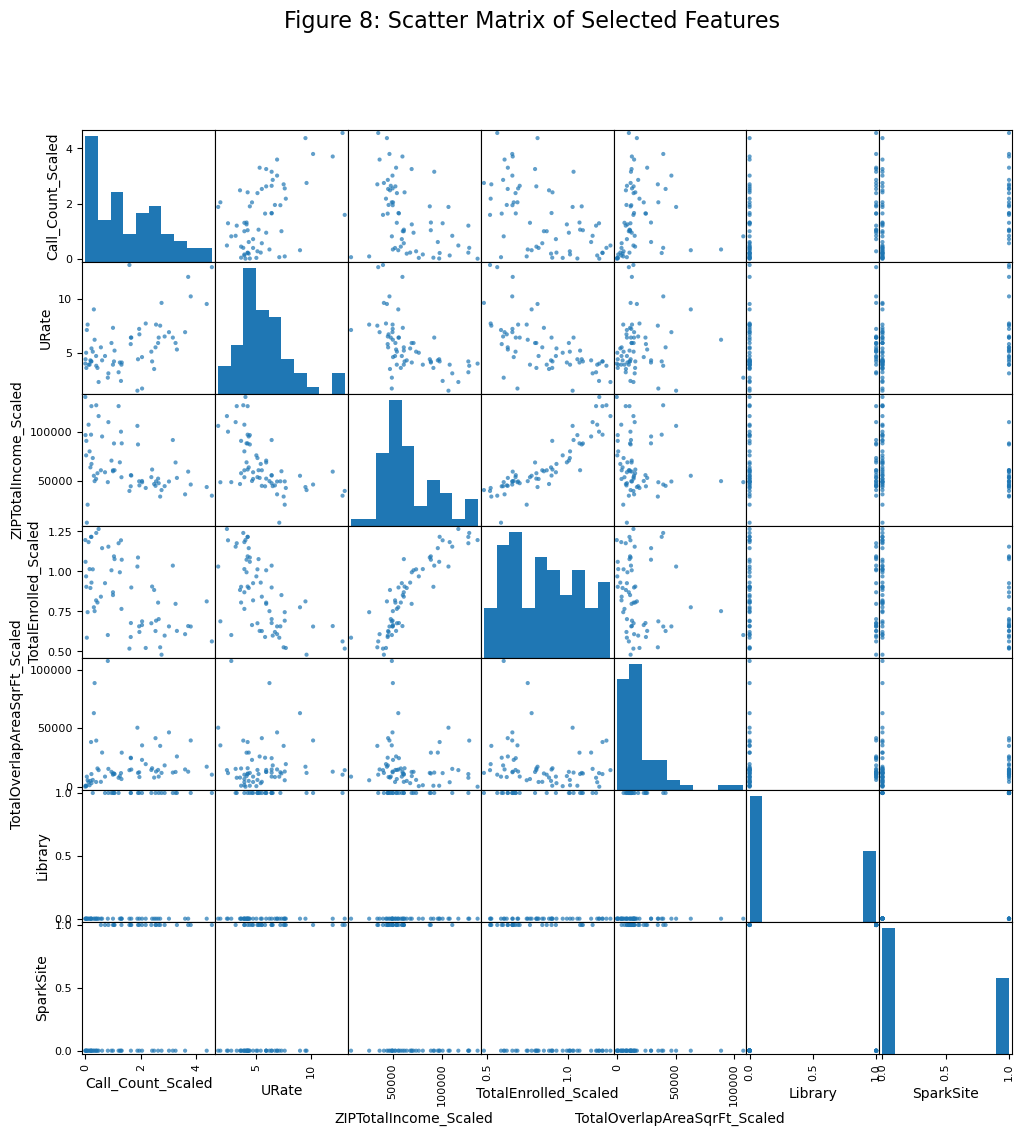

In [25]:
from pandas.plotting import scatter_matrix

# Plot scatter matrix
scatter_matrix(merged_df[features], figsize=(12, 12), alpha=0.7, diagonal='hist')

plt.suptitle("Figure 8: Scatter Matrix of Selected Features", fontsize=16)
plt.show()

### Heatmap and correlation plots

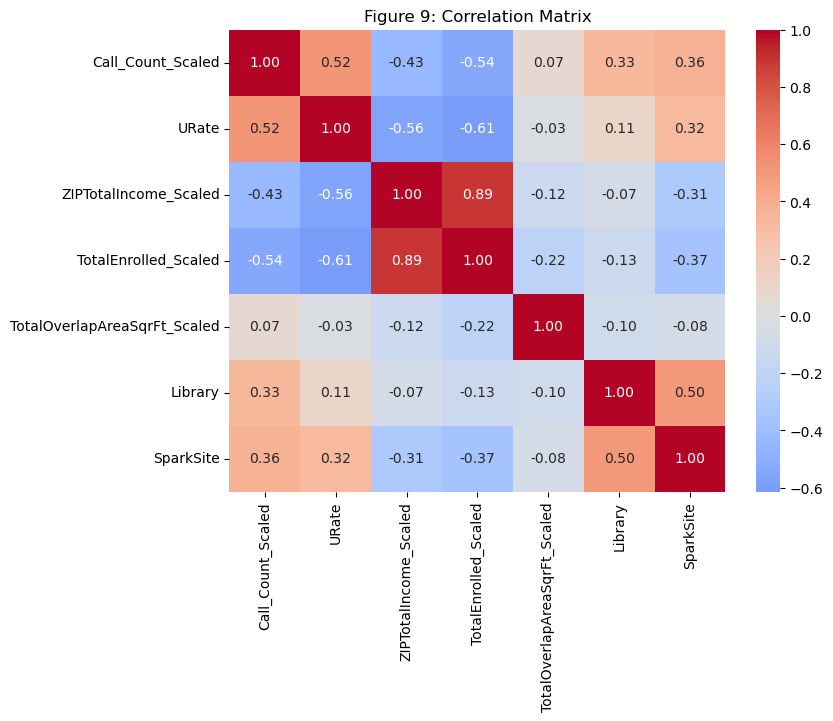

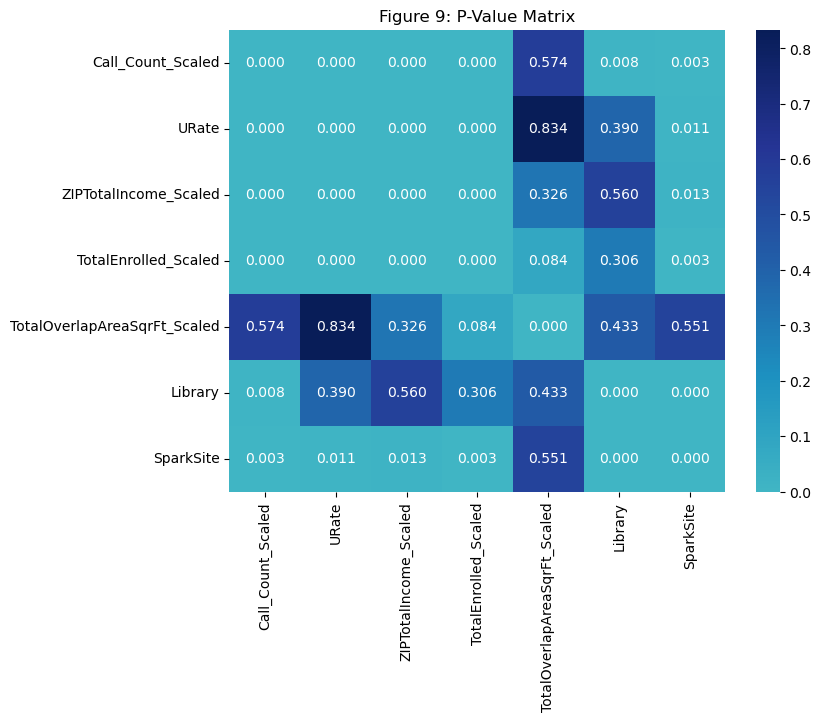

In [26]:
import numpy as np
from scipy.stats import pearsonr

# Initialize
data = merged_df[features]
corr_matrix = pd.DataFrame(index=features, columns=features, dtype=float)
pval_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

# Calculate correlation and p-values
for col1 in features:
    for col2 in features:
        corr, pval = pearsonr(data[col1], data[col2])
        corr_matrix.loc[col1, col2] = corr
        pval_matrix.loc[col1, col2] = pval

# Correlation and p-value matrices
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Figure 9: Correlation Matrix")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix, annot=True, fmt=".3f", cmap="YlGnBu", center=0)
plt.title("Figure 9: P-Value Matrix")
plt.show()


Correlation matrix interpretation:
#### Calls for Service per WAP

- **Unemployment Rate**  
  Shows a moderate positive correlation with Calls for Service per WAP (**r = 0.52**).  
  This correlation is **statistically significant (p < 0.001)**.

- **Income per Work-Age Person**  
  Displays a moderate negative correlation (**r = -0.43**) with Calls for Service per WAP.  
  This correlation is **statistically significant (p < 0.001)**.

- **College Enrollment per Work-Age Person**  
  Also moderately negatively correlated with Calls for Service per WAP (**r = -0.54**).  
  The relationship is **statistically significant (p < 0.001)**.

- **SAFFE Zone Area per WAP**  
  Very weak positive correlation (**r = 0.07**) with Calls for Service per WAP.  
  However, this result is **not statistically significant (p = 0.574)**.

- **Library Presence (1/0)**  
  Weak-to-moderate positive correlation (**r = 0.33**) with Calls for Service per WAP.  
  This is **statistically significant (p = 0.008)**.

- **School Park Presence (1/0)**  
  Weak-to-moderate positive correlation (**r = 0.37**) with Calls for Service per WAP.  
  This relationship is also **statistically significant (p = 0.003)**.

### Inter-Feature Correlation

- **College Enrollment per WAP** and **Income per WAP**  
  Strong positive correlation (**r = 0.89**).  
  This is **statistically significant (p < 0.001)**.  
  *High posibility in multicollinearity.

- **Unemployment Rate** and **College Enrollment per WAP**  
  Strong negative correlation (**r = -0.61**).  
  This is **statistically significant (p < 0.001)**.  
  May also contribute to multicollinearity in regression models.

- **Library Presence** and **School Park Presence**  
  Moderate positive correlation (**r = 0.50**).  
  **Statistically significant (p < 0.001)**.  
  Indicates these community features often co-exist in ZIP codes.


## Linear Modeling

Based on the observed correlations and statistical significance, we build the following Ordinary Least Squares (OLS) model:

$$
\begin{align*}
\text{CallsForService}_{\text{WAP}} =\ & \beta_0
+ \beta_1\, \text{UnemploymentRate}
+ \beta_2\, \text{Income}_{\text{WAP}} \\
& + \beta_3\, \text{CollegeEnrollment}_{\text{WAP}}
+ \beta_4\, \text{Library}
+ \beta_5\, \text{SchoolPark}
+ \varepsilon
\end{align*}
$$

The subscript $\text{WAP}$ is used as a convention to indicate that the variable has been scaled per Work Age Person.


In [27]:
import statsmodels.api as sm

# Set predictors
predictors = ['URate',
              'ZIPTotalIncome_Scaled',
              'TotalEnrolled_Scaled',
              'Library',
              'SparkSite']

X = merged_df_standardized[predictors]
y = merged_df_standardized["Call_Count_Scaled"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Call_Count_Scaled   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     8.559
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           4.06e-06
Time:                        14:53:47   Log-Likelihood:                -73.128
No. Observations:                  64   AIC:                             158.3
Df Residuals:                      58   BIC:                             171.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.19

Based on the correlation matrix, Income per WAP shows high correlation (possible collinearity) with College Enrollment per WAP. Since it is not statistically significant in the model (p = 0.327), we chose to remove it to improve interpretability. We also removed School Park presence since it is not statistically significant.

Our new OLS model is:

$$
\begin{aligned}
\text{CallsForService}_{\text{WAP}} =\ & \beta_0
+ \beta_1\, \text{UnemploymentRate} \\
& + \beta_2\, \text{CollegeEnrollment}_{\text{WAP}} \\
& + \beta_3\, \text{Library}
+ \varepsilon
\end{aligned}
$$

In [28]:
# Set predictors
predictors = ['URate',
              'TotalEnrolled_Scaled',
              'Library']
X = merged_df_standardized[predictors]
y = merged_df_standardized["Call_Count_Scaled"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Call_Count_Scaled   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     14.12
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           4.51e-07
Time:                        14:53:47   Log-Likelihood:                -73.718
No. Observations:                  64   AIC:                             155.4
Df Residuals:                      60   BIC:                             164.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1894 

R-squared = 0.414, Adj. R-squared = 0.385
→ The model explains about 41.4% of the variance in Calls for Service per WAP, with a reasonably good adjusted value, especially for cross-sectional data

- **Model Fit**  
  **R-squared**: 0.414  
  **Adjusted R-squared**: 0.385  
  **F-statistic**: 14.12, p-value: 4.51e-07  

  The model is statistically significant overall.

- **Interpretation of Coefficients**

  **Unemployment Rate**: +0.285 (p = 0.026)  
  Statistically significant. Higher unemployment rates are associated with more calls per WAP.

  **TotalEnrolled_Scaled**: –0.336 (p = 0.010)  
  Statistically significant. Higher college enrollment per WAP is associated with fewer calls per WAP.

  **Library**: +0.5271 (p = 0.014)  
  Statistically significant. Areas with a library tend to have more calls per WAP.


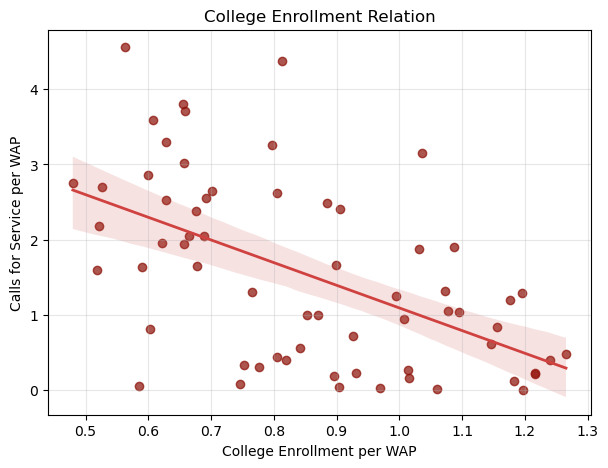

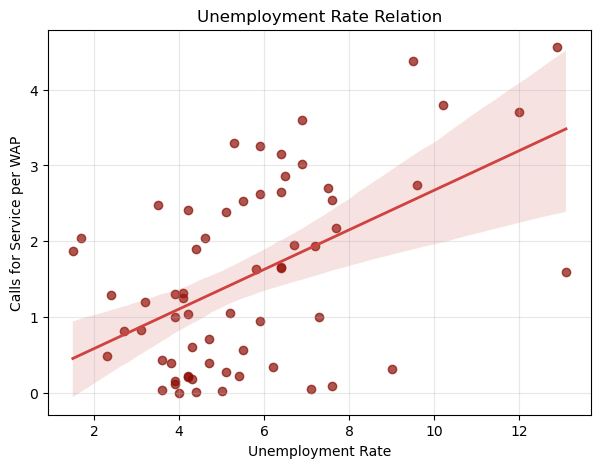

/var/folders/1w/byd48zb55rnbh_x6sbljbvg40000gn/T/ipykernel_15052/725301634.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


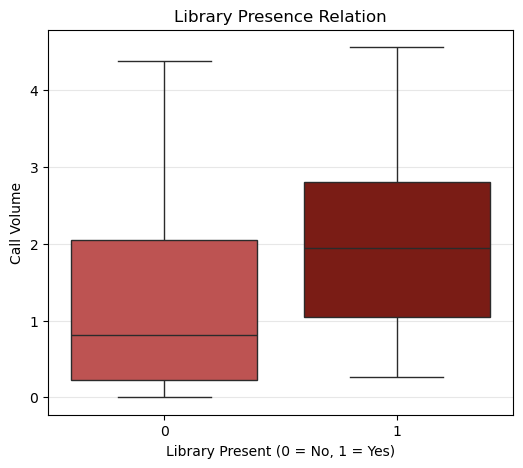

In [29]:
# College Enrollment
plt.figure(figsize=(7, 5))
sns.regplot(
    x=merged_df["TotalEnrolled_Scaled"],
    y=merged_df["Call_Count_Scaled"],
    scatter_kws={"alpha": 0.7, "color": "#8B0E04"},
    line_kws={"color": "#CF4240", "linewidth": 2},
)
plt.xlabel("College Enrollment per WAP")
plt.ylabel("Calls for Service per WAP")
plt.title("College Enrollment Relation")
plt.grid(True, alpha=0.3)
# plt.savefig("scatter_college_vs_calls.png", dpi=300, bbox_inches='tight')
plt.show()

# Unemployment Rate
plt.figure(figsize=(7, 5))
sns.regplot(
    x=merged_df["URate"],
    y=merged_df["Call_Count_Scaled"],
    scatter_kws={"alpha": 0.7, "color": "#8B0E04"},
    line_kws={"color": "#CF4240", "linewidth": 2},
)
plt.xlabel("Unemployment Rate")
plt.ylabel("Calls for Service per WAP")
plt.title("Unemployment Rate Relation")
plt.grid(True, alpha=0.3)
# plt.savefig("scatter_urate_vs_calls.png", dpi=300, bbox_inches='tight')
plt.show()

# Library Presence
plt.figure(figsize=(6, 5))
sns.boxplot(
    x=merged_df["Library"],
    y=merged_df["Call_Count_Scaled"],
    palette=["#CF4240", "#8B0E04"]
)
plt.xlabel("Library Present (0 = No, 1 = Yes)")
plt.ylabel("Call Volume")
plt.title("Library Presence Relation")
plt.grid(True, axis='y', alpha=0.3)
# plt.savefig("boxplot_calls_by_library.png", dpi=300, bbox_inches='tight')
plt.show()


In [30]:
from scipy.stats import mannwhitneyu

# Split into groups
calls_no_library = merged_df[merged_df["Library"] == 0]["Call_Count_Scaled"]
calls_with_library = merged_df[merged_df["Library"] == 1]["Call_Count_Scaled"]

# Run non-parametric test
stat, p_value = mannwhitneyu(calls_no_library, calls_with_library, alternative='two-sided')

print("Mann-Whitney U Test Statistic:", stat)
print("p-value:", p_value)


Mann-Whitney U Test Statistic: 269.0
p-value: 0.004707841585216214


Mann-Whitney U Test: Since the p-value is 0.0047, we reject the null hypothesis and conclude that the distribution of calls for service per WAP is significantly different between areas with and without a library.

<a id="observations-and-recommendation"></a>

# Observations and Recommendation

When modeling the standardized features, higher unemployment is positively associated with calls per WAP. Greater college enrollment per WAP shows a negative association, indicating fewer calls. The coefficient for the presence of a library is also positive and statistically significant, which does not necessarily imply that libraries contribute to more calls. It could be that they may be located in areas with higher need for public services due to other factors we have yet to explore. Based on these findings, the recommendation is to prioritize educational access and employment opportunities in ZIP codes with high calls for service per WAP, since these variables show the most consistent statistical association with reduced calls for service.